# Clickabit detection using informativeness measures

In [44]:
import warnings
import unicodedata
import string 

import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
import textstat
from lexical_diversity import lex_div

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import math

In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /home/tymek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## Metrics

In [12]:
text = "This1 is the best sample text, bro! 277 green car"

In [ ]:
sum([x.isnumeric() for x in word_tokenize(text)]) / len(word_tokenize(text))

0.14285714285714285

1.000631880307906

In [13]:
words = word_tokenize(text)
tagged_words = pos_tag(words)

In [14]:
tagged_words

[('This1', 'NNP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('best', 'JJS'),
 ('sample', 'NN'),
 ('text', 'NN'),
 (',', ','),
 ('bro', 'NN'),
 ('!', '.'),
 ('277', 'CD'),
 ('green', 'JJ'),
 ('car', 'NN')]

In [30]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
def number_of_words(text):
    """ calculates number of words """
    return len(text.split())

def number_of_characters(text):
    """ calculates number of characters including whitespaces """
    return len(text.strip())

def mean_word_length(text):
    """ calculates average word length """
    return float(np.mean([len(word) for word in word_tokenize(remove_punctuation(text))]))

def common_words_percentage(text, language="english"):
    """ percentage of stop words in text """
    words = word_tokenize(remove_punctuation(text))
    stop_words = stopwords.words(language)
    common_words = [word for word in words if word.lower() in stop_words]
    return len(common_words) / len(words)

def capital_letters_ratio(text):
    """ callculates capital letters ratio """
    return sum([char.isupper() for char in list(text)]) / len(text)

def punctuation_ratio(text):
    """ calculates punctuation ratio """
    return sum([1 for x in text if x in string.punctuation]) / len(text)

def uncommon_punctuation_ratio(text):
    """ calculates punctuation ratio """
    uncommon_punctuation = string.punctuation.replace(".", "").replace(",", "").replace("'", "")
    return sum([1 for x in text if x in uncommon_punctuation]) / len(text)

def numbers_ratio(text):
    """ calculates ratio of numbers (not digits) to words """
    text = remove_punctuation(text)
    return sum([x.isnumeric() for x in word_tokenize(text)]) / len(word_tokenize(text))

def pronouns_usage(text):
    """ pronouns usage """
    def is_pronoun(word):
        tagged = pos_tag(word)
        return tagged[0][1] in ('PRP', 'PRP$', 'WP', 'WP$')
    return sum([is_pronoun(x) for x in word_tokenize(text)])

def pronouns_2nd_person_usage(text):
    """ 2nd person pronouns usage """
    second_person_pronouns = ["you", "your", "yours", "yourself", "yourselves"]
    return sum([1 for x in word_tokenize(text) if x in second_person_pronouns])

def superlatives_usage(text):
    """ percentage of adjectives and adverbs which are in superlative form """
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    adj_adv_count = 0
    superlative_count = 0
    for _, tag in tagged_words:
        if tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'):
            adj_adv_count += 1
            if tag in ('JJS', 'RBS'):  # if superlative
                superlative_count += 1
    if adj_adv_count == 0:
        return 0
    return superlative_count / adj_adv_count

def speculatives(text):
    """ usage of speculative forms """
    speculative_words = {
        "might", "may", "could", "can", "perhaps", "possibly", "probably", "maybe",
        "seems", "appears", "suggests", "indicates", "likely", "unlikely", "assume"
    }
    return sum([1 for x in word_tokenize(text) if x in speculative_words])

def baiting_words_usage(text):
    """ ratio number of baiting words used """
    bait_words = {"sexy", "nudes", "OMG", "TWEETS", "VIDEO"}
    return sum([1 for x in word_tokenize(text) if x in bait_words])

def similarity_score(text):
    """ embeddings and cosine similarity """
    pass

def sentiment_score(text):
    """ from eda """
    pass

def type_token_ratio(text):
    """ lexical richness """
    words = word_tokenize(remove_punctuation(text))
    unique_words = set(words)
    return len(unique_words) / len(words)

def corrected_type_token_ratio(text):
    """ lexical richness """
    words = word_tokenize(remove_punctuation(text))
    unique_words = set(words)
    return len(unique_words) / np.sqrt(2 * len(words))

def mass_index(text):
    """ lexical diversity index """
    n = len(word_tokenize(remove_punctuation(text)))
    t = len(set(words))
    return (math.log(n) - math.log(t)) / (math.log(n) ** 2)

def hdd_metric(text):
    """ hypergeometric distribution D, lexical diversity """
    words = word_tokenize(remove_punctuation(text))
    if len(words) < 42:
        message = f"The text is {len(words)} words long. HD-D metric is not defined for texts with less than 42 tokens."
        warnings.warn(message, UserWarning)
    return lex_div.hdd(words)

def flesch_reading_ease_score(text):
    """ difficulty of the text, if its easy to read or not, the higher the easier
    
    Formula:
    206.835 - 1.015 * (total words / total sentences) - 84.6 (total syllables / total words)

    Scores:
    -90.00  	Very easy to read. Easily understood by an average 11-year-old student.
    90.0-80.0	Easy to read. Conversational English for consumers.
    80.0-70.0	Fairly easy to read.
    70.0-60.0	Plain English. Easily understood by 13- to 15-year-old students.
    60.0-50.0	Fairly difficult to read.
    50.0-30.0	Difficult to read.
    30.0-10.0	Very difficult to read. Best understood by university graduates.
    10.0-   	Extremely difficult to read. Best understood by university graduates.
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_reading_ease(text)

def flesch_kincaid_grade_level(text):
    """ difficulty of the text, US grade level needed to understand the text quite easily, the higher the harder

    Formula:
    0.39 * (total words / total sentences) + 11.8(total syllables / total words) - 15.59

    can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_kincaid_grade(text)

def automated_readability_index(text):
    """ difficulty of the text, US grade level necessary to comprehend the text, the higher the harder

    Formula:
    4.71 * (characters / words) + 0.5 (words / sentences) - 21.43

    Scores:
    score | age | grade level
    1	5-6	    Kindergarten
    2	6-7	    First Grade
    3	7-8	    Second Grade
    4	8-9	    Third Grade
    5	9-10	Fourth Grade
    6	10-11	Fifth Grade
    7	11-12	Sixth Grade
    8	12-13	Seventh Grade
    9	13-14	Eighth Grade
    10	14-15	Ninth Grade
    11	15-16	Tenth Grade
    12	16-17	Eleventh Grade
    13	17-18	Twelfth Grade
    14	18-22	College student
    source: https://en.wikipedia.org/wiki/Automated_readability_index
    """
    return textstat.automated_readability_index(text)


In [5]:
metrics_functions = {
    "n_words": number_of_words,
    "n_characters": number_of_characters,
    "cw_percentage": common_words_percentage,
    "ttr": type_token_ratio,
    "cttr": corrected_type_token_ratio,
    "hdd": hdd_metric,
    "fres": flesch_reading_ease_score,
    "fkgl": flesch_kincaid_grade_level,
    "ari": automated_readability_index
}

## Preprocessing

In [6]:
raw_data = pd.read_csv("../data/cc_dataset_balanced.csv")

In [7]:
# drop NA
raw_data = raw_data.drop(raw_data[raw_data['body'].isna()].index)
data = raw_data.copy()

In [8]:
# clean escape characters
data['body'] = data['body'].apply(lambda x: unicodedata.normalize('NFKC', x))

## EDA & models

#### Title analysis

In [9]:
data_metrics = data.copy()

In [10]:
# apply metrics
for name, function in metrics_functions.items():
    if name != "hdd":
        data_metrics[name] = data_metrics['title'].apply(function)

array([[<Axes: title={'center': 'clickbait'}>,
        <Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>],
       [<Axes: title={'center': 'cw_percentage'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>],
       [<Axes: title={'center': 'fres'}>,
        <Axes: title={'center': 'fkgl'}>,
        <Axes: title={'center': 'ari'}>]], dtype=object)

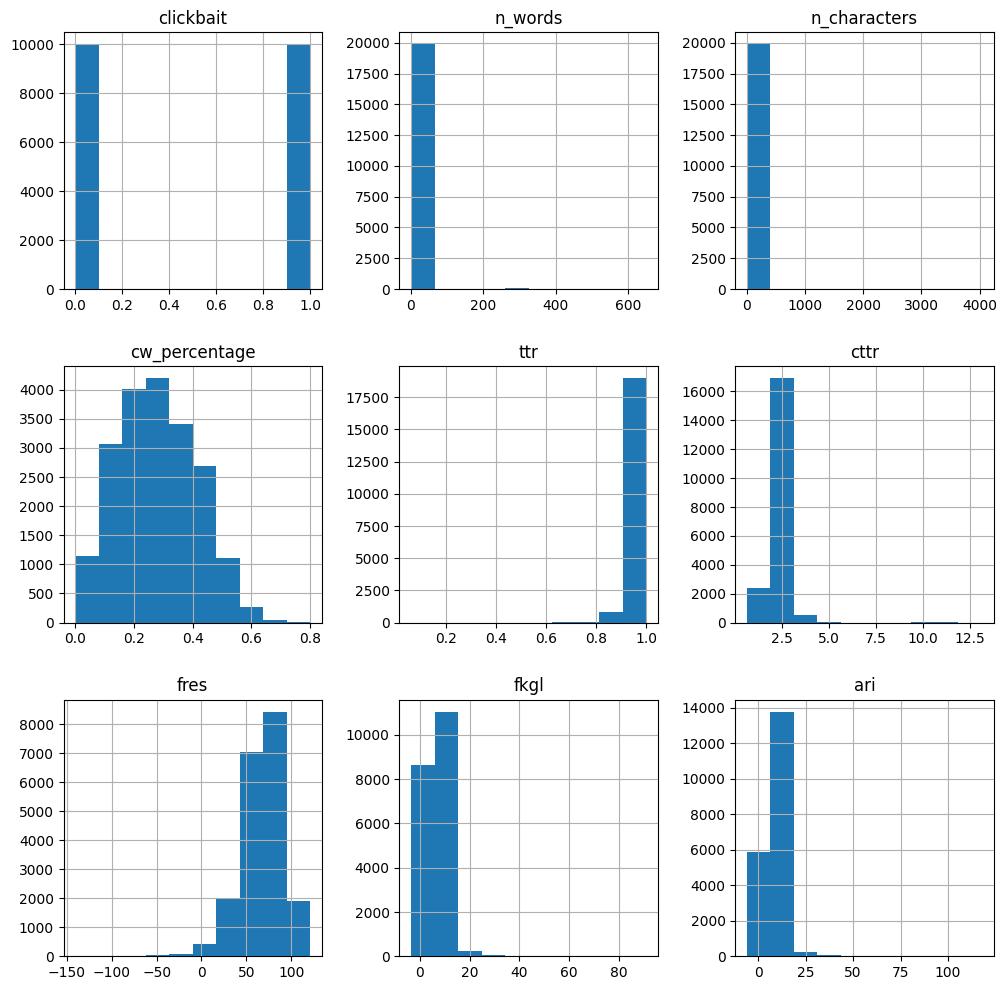

In [245]:
# check histograms
data_metrics.drop(['title', 'body'], axis=1).hist(figsize=(12,12))

Histograms for n_words and n_characters look bad. There are some outliers, possibly because of flaws in data scraping, for example:

In [246]:
# example of problematic title
long_titles = data_metrics[data_metrics['n_words'] > 100]
long_titles['title'].iloc[0]

"Sections Shows Live Yahoo!-ABC News Network | © 2017 ABC News Internet Ventures. All rights reserved. ABC News DC Mansion Murders: Investigators Find Apparently Bloody Bat in House Apparently Bloody Bat Found in DC Mansion Case Trump was talking about general surveillance in wiretapping claims, Spicer says GOP congressman defends racially charged tweet against critics States seeking Trump travel ban block want new hearing Verizon sought $925 million penalty for Yahoo's lax security Abrupt dismissals leave US attorneys scrambling Shots fired at Ferguson protest sparked by new documentary Carlos the Jackal regrets not killing 'people I should have' Photography project captures 'first hello' between parents and newborns Pregnant woman rewards man who offered his seat with a custom trophy Mom reunited with lost family video found at Goodwill Villanova's 2016 March Madness win recreated with Legos Disinfecting agent turns Canada city's water bright pink Friar dog adopted by monastery becom

In [247]:
# mean
print(f"mean number of words: {round(np.mean(data_metrics['n_words']), 1)}\n")
# percentiles
q_percentiles = [90, 99, 99.5, 99.7]
percentiles = np.percentile(data_metrics['n_words'], q_percentiles)
print(f"Percentiles:\nq: {q_percentiles}\n{percentiles}")

mean number of words: 12.5

Percentiles:
q: [90, 99, 99.5, 99.7]
[ 16.     30.     36.    211.885]


In [253]:
# clickbait / non-clickbait ratio
long_titles = data_metrics[data_metrics['n_words'] > 40]
print("", long_titles['clickbait'].value_counts())

 clickbait
0    42
1    41
Name: count, dtype: int64


Looking at the percentiles we can safely delete all titles longer than 40 words, also the ratio of target variable won't be disturbed

In [254]:
# dropping outliers
shortened_metrics = data_metrics[data_metrics['n_words'] < 40]

array([[<Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>]], dtype=object)

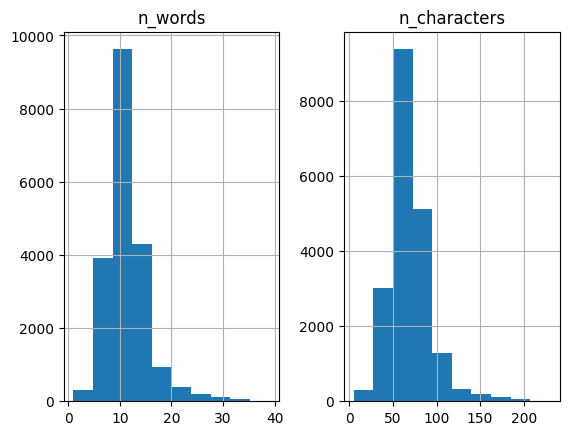

In [256]:
# check histograms again
shortened_metrics[['n_words', 'n_characters']].hist()

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

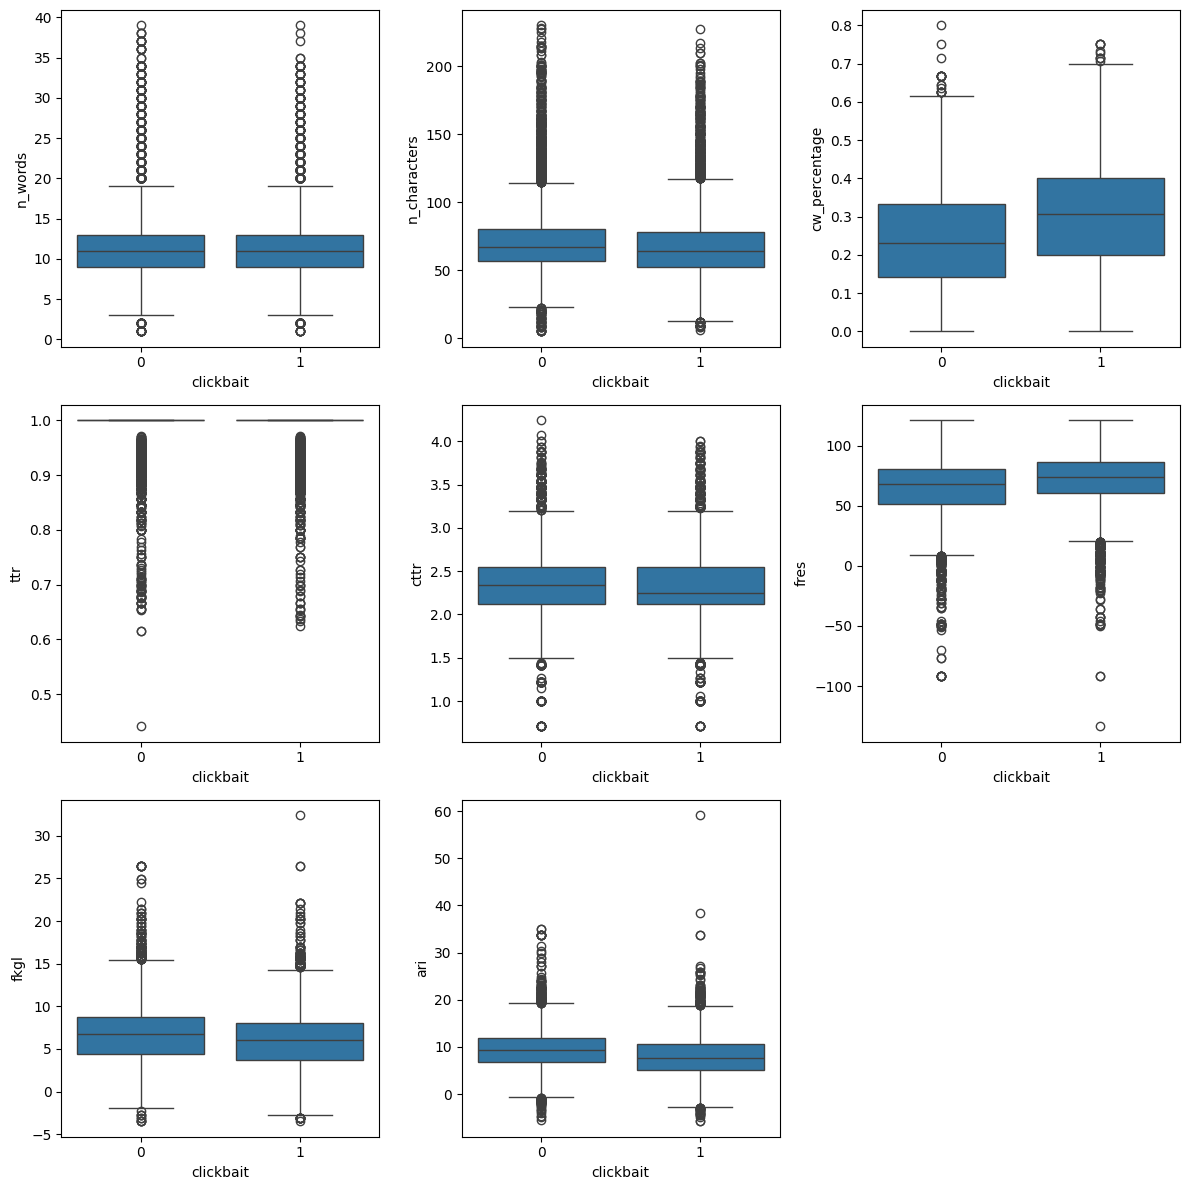

In [277]:
plt.figure(figsize=(12,12))
columns = shortened_metrics.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='clickbait', y=col, data=shortened_metrics)
plt.tight_layout()
plt.show()

Half of the measures have almost identical characteristics for bait and non-bait. There are differences for some variables, but they are rather not substantial (metrics measuring difficulty of the text). The only clear difference is in average percentage of common words, which is higher for clickbaits.

Fitting models:

<Axes: >

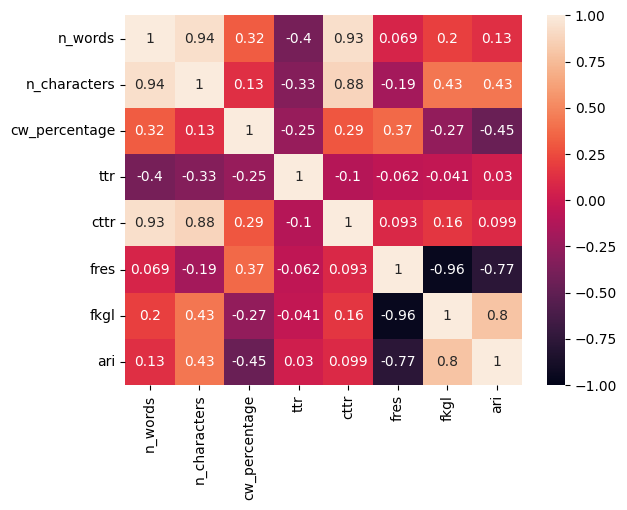

In [370]:
# check corelation
X = shortened_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = shortened_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

<Axes: >

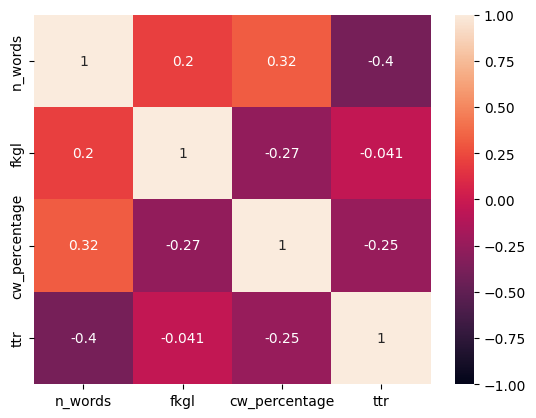

In [421]:
# dropping correlated columns 'n_characters', 'cttr', 'fres', 'ari'
X = shortened_metrics[['n_words', 'fkgl', 'cw_percentage', 'ttr']]
y = shortened_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [423]:
# split and prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [425]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14890
Method:                           MLE   Df Model:                            3
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                 0.05479
Time:                        13:48:38   Log-Likelihood:                -9758.1
converged:                       True   LL-Null:                       -10324.
Covariance Type:            nonrobust   LLR p-value:                6.232e-245
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words          -0.1743      0.020     -8.608      0.000      -0.214      -0.135
fkgl             -0.

In [426]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2495
           1       0.61      0.57      0.59      2470

    accuracy                           0.60      4965
   macro avg       0.60      0.60      0.60      4965
weighted avg       0.60      0.60      0.60      4965



The only insignificant variable is ttr, so lets drop it and fit a model again

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['ttr'], axis=1), y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.655192
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14891
Method:                           MLE   Df Model:                            2
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                 0.05476
Time:                        13:52:52   Log-Likelihood:                -9758.4
converged:                       True   LL-Null:                       -10324.
Covariance Type:            nonrobust   LLR p-value:                3.122e-246
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words          -0.1794      0.019     -9.369      0.000      -0.217      -0.142
fkgl             -0.

We got better accuracy, but it's impossible to build a good model based only of informativeness measures of title. Also, most of them are correlated, so its enough to choose only some of them (eg n_words, fkgl, cw_percentage). 

Conclusions from the model - headlines which are easier to read (fkgl), contain less words, but have higher common words percentage are more likely to be classified as clickbait.

For the sake of testing, lets put all the variables to random forest:

In [431]:
X = shortened_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = shortened_metrics['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      2495
           1       0.58      0.57      0.58      2470

    accuracy                           0.58      4965
   macro avg       0.58      0.58      0.58      4965
weighted avg       0.58      0.58      0.58      4965



#### Body analysis

In [11]:
body_metrics = data.copy()

In [12]:
# apply metrics
for name, function in metrics_functions.items():
    body_metrics[name] = body_metrics['body'].apply(function)

/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 11 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 3 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 35 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 4 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 27 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 40 words long. HD-D metric is not defined for text

array([[<Axes: title={'center': 'clickbait'}>,
        <Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>],
       [<Axes: title={'center': 'cw_percentage'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>],
       [<Axes: title={'center': 'hdd'}>,
        <Axes: title={'center': 'fres'}>,
        <Axes: title={'center': 'fkgl'}>],
       [<Axes: title={'center': 'ari'}>, <Axes: >, <Axes: >]],
      dtype=object)

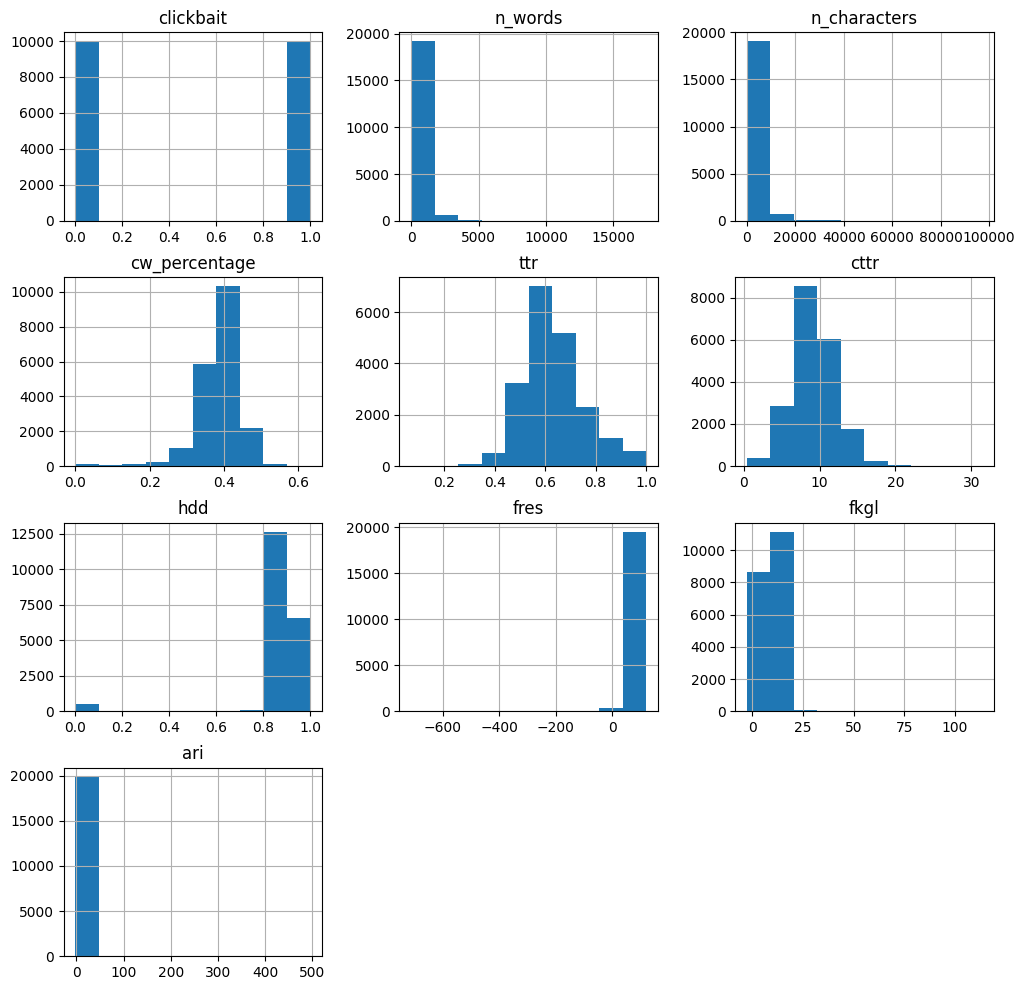

In [50]:
# check histograms
body_metrics.drop(['title', 'body'], axis=1).hist(figsize=(12,12))

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

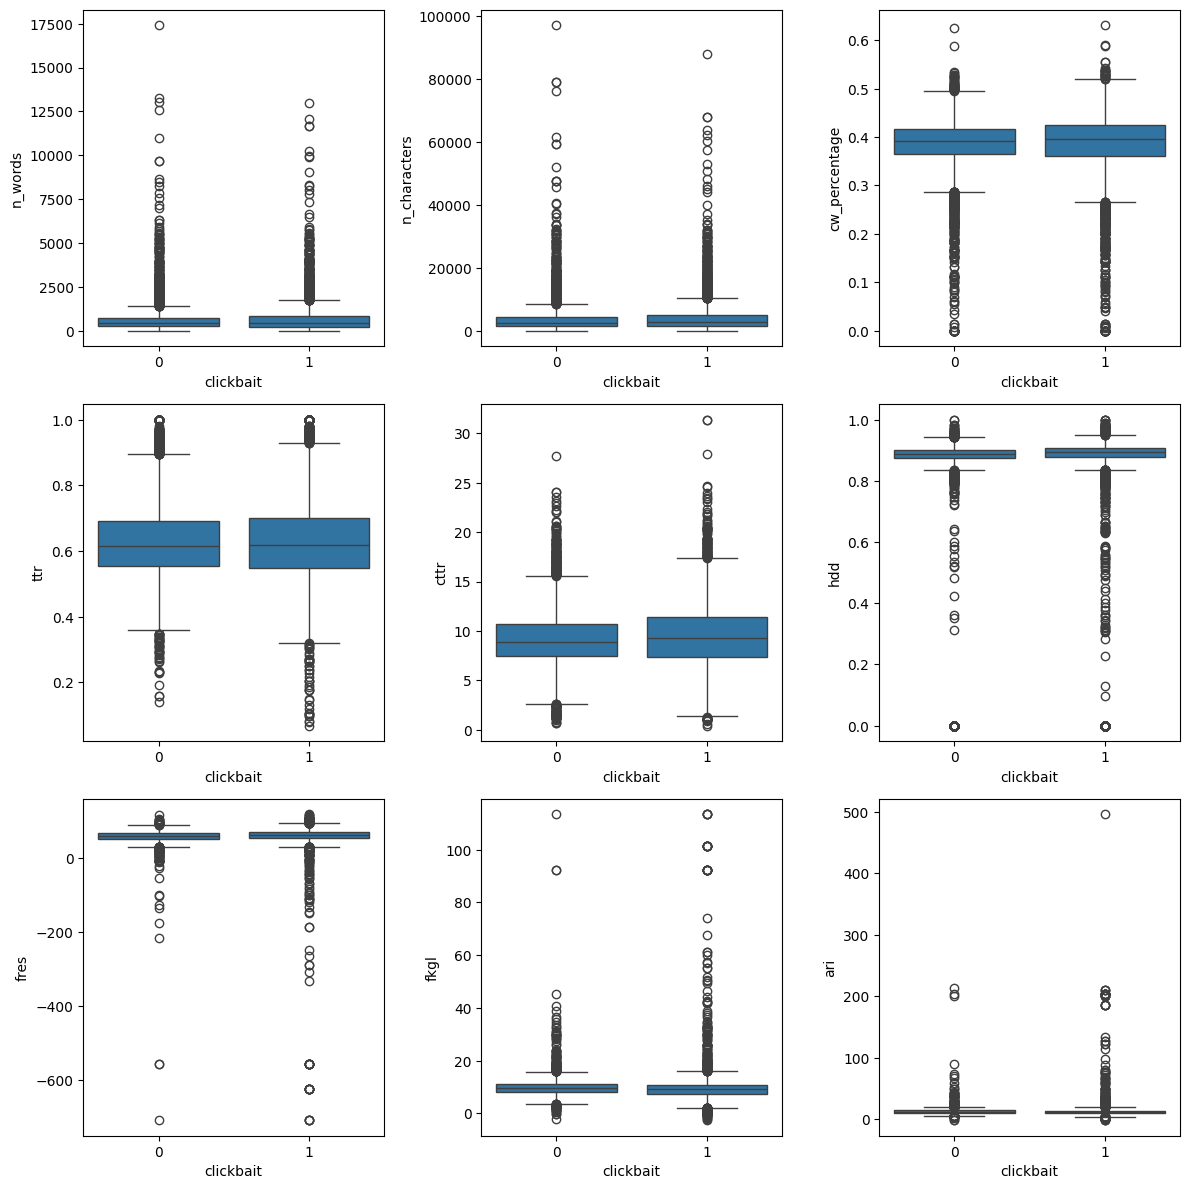

In [51]:
plt.figure(figsize=(12,12))
columns = body_metrics.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='clickbait', y=col, data=body_metrics)
plt.tight_layout()
plt.show()

Due to some outliers, its hard to see the relationships. Lets print some numerical metrics

In [52]:
def calculate_stats(series: pd.Series):
    stats_data = {
'mean': series.mean(),
'median': series.median(),
'q1': series.quantile(0.25),
'q3': series.quantile(0.75),
'std': series.std()
    }
    return pd.DataFrame(stats_data)
    
columns = body_metrics.columns.to_list()[3:]
for i, col in enumerate(columns):
    print(f"\n-----\n{col.upper()}")
    stats = calculate_stats(body_metrics.groupby('clickbait')[col])
    print(stats)



-----
N_WORDS
                 mean  median     q1     q3         std
clickbait                                              
0          586.317339   428.0  249.0  723.5  675.872227
1          633.739331   468.0  237.0  844.0  687.075970

-----
N_CHARACTERS
                  mean  median      q1      q3          std
clickbait                                                  
0          3515.115396  2580.0  1487.0  4352.0  3984.775383
1          3764.405663  2781.0  1405.0  5010.0  4058.578888

-----
CW_PERCENTAGE
               mean    median        q1        q3       std
clickbait                                                  
0          0.385966  0.391844  0.364511  0.416792  0.054047
1          0.388254  0.395381  0.361139  0.424869  0.061477

-----
TTR
               mean    median        q1        q3       std
clickbait                                                  
0          0.630099  0.615079  0.554392  0.690476  0.113783
1          0.633000  0.617155  0.548706  0.701276

Generally all stats look quite similar. The only clear pattern is that the standard deviation (across all measures) is bigger for clickabaits.

Fitting models:

<Axes: >

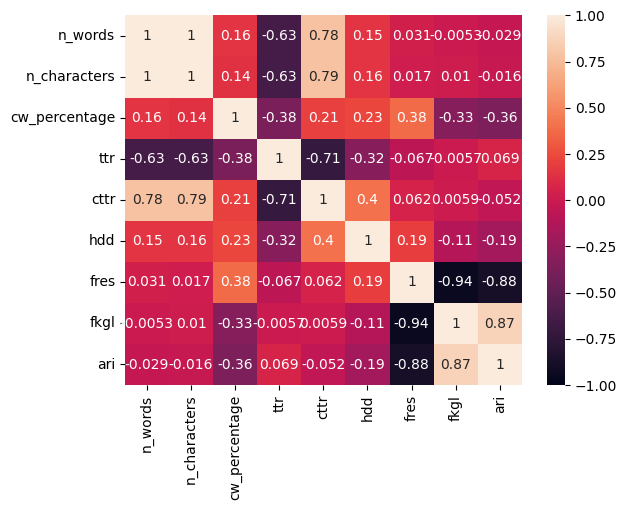

In [53]:
# check corelation
X = body_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = body_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

<Axes: >

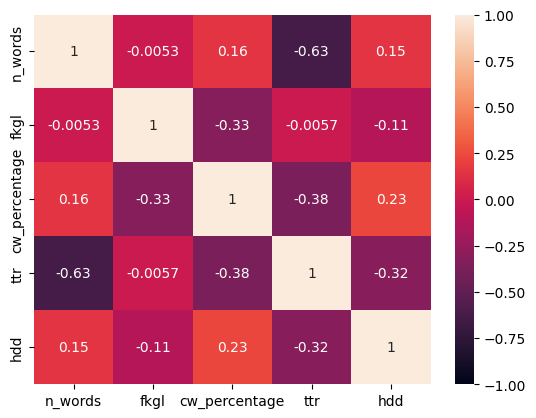

In [54]:
# dropping correlated columns 'n_characters', 'cttr', 'fres', 'ari'
X = body_metrics[['n_words', 'fkgl', 'cw_percentage', 'ttr', 'hdd']]
y = body_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [55]:
# split and prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [56]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.689836
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14956
Model:                          Logit   Df Residuals:                    14951
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                0.004777
Time:                        19:58:44   Log-Likelihood:                -10317.
converged:                       True   LL-Null:                       -10367.
Covariance Type:            nonrobust   LLR p-value:                 1.571e-20
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words           0.1307      0.024      5.494      0.000       0.084       0.177
fkgl             -0.

In [57]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58      2509
           1       0.56      0.51      0.53      2477

    accuracy                           0.56      4986
   macro avg       0.56      0.56      0.56      4986
weighted avg       0.56      0.56      0.56      4986



There is also big corelation between only n_words and ttr, so lets drop one and fit a model again

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['ttr'], axis=1), y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.690829
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14956
Model:                          Logit   Df Residuals:                    14952
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                0.003344
Time:                        19:59:02   Log-Likelihood:                -10332.
converged:                       True   LL-Null:                       -10367.
Covariance Type:            nonrobust   LLR p-value:                 5.927e-15
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words           0.0507      0.017      2.956      0.003       0.017       0.084
fkgl             -0.

Again we got better accuracy after dropping ttr, but still information measures are not good enough to build a proper model.

Lets try to fit random forest with all the variables:

In [60]:
X = body_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = body_metrics['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      2509
           1       0.61      0.59      0.60      2477

    accuracy                           0.61      4986
   macro avg       0.61      0.61      0.61      4986
weighted avg       0.61      0.61      0.61      4986



#### Combined

In [13]:
# prepare body data
body_dropped = body_metrics.drop(['title', 'body'], axis=1)
body_dropped.columns = ['body_' + col if col != 'clickbait' else col for col in body_dropped.columns]

In [14]:
# prepare title data
title_dropped = data_metrics.drop(['title', 'body', 'clickbait'], axis=1)
title_dropped.columns = ['title_' + col for col in title_dropped.columns]

In [15]:
all_data = pd.concat([body_dropped, title_dropped], axis=1)

In [23]:
X = all_data.drop(['clickbait', 'body_cw_percentage', 'body_fres', 'title_n_characters', 'body_n_characters', 'title_fres', 'title_ari', 'body_hdd'], axis=1)
y = all_data['clickbait']

# split and prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.649865
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14956
Model:                          Logit   Df Residuals:                    14946
Method:                           MLE   Df Model:                            9
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                 0.06244
Time:                        21:56:35   Log-Likelihood:                -9719.4
converged:                       True   LL-Null:                       -10367.
Covariance Type:            nonrobust   LLR p-value:                4.389e-273
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
body_n_words           -0.0647      0.029     -2.204      0.027      -0.122      -0.007
bo

In [32]:
X = all_data.drop(['clickbait', 'body_n_characters', 'body_cttr', 'body_fres', 'title_n_characters', 'title_cttr', 'title_fres', 'title_ari'], axis=1)
y = all_data['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2509
           1       0.65      0.65      0.65      2477

    accuracy                           0.65      4986
   macro avg       0.65      0.65      0.65      4986
weighted avg       0.65      0.65      0.65      4986



Not something we were hoping for...